<div align="center">

**OPTIMIZATION FOR DATA SCIENCE -- PROJECT**
<br><br><br>
***FIRST ORDER OPTIMIZATION METHODS:***  
**a Comparative Analysis of the Projected Gradient Method and the Frank-Wolfe Algorithm on Portfolio Optimization**

---

(Lazzari Tommaso · Ludergnani Brenno · Movila Dumitru · Safa Nasser  )

</div>

# **PORTFOLIO PROBLEM**

OBJECTIVE FUNCTION

$f(x) = x^\top \Sigma x - \eta \cdot \mu^\top x$

In [74]:
#objective function (Markowitz)

#def f
###inputs:
#   x : portfolio weights
#   Sigma : covariance matrix of assets' returns
#   mu : vector of expected returns
#   eta : risk tolerance hyperparameter
#         high-eta : represent higher risk (variance) tolerance favoring higher returns
#         low-eta : favors a more cautious investment strategy

def f(x, Sigma, mu, eta):
  return (x.T @ Sigma @ x) - eta*mu.T @ x


#Sigma is positive semidefinite -> f is a convex quadratic function in x

DERIVATIVE

$\nabla f(x) = 2\Sigma x - \eta \mu$

In [75]:
#derivative of the objective function

def grad_f(x, Sigma, mu, eta):
  return 2 * Sigma @ x - eta*mu

# **FRANK-WOLFE ALGORITHMS**

The constraint is that we can not allow short selling, which means that portfolio weights must lie on the unit simplex:

$\mathcal{C} = \left\{ x \in \mathbb{R}^n \,\middle|\, \sum_{i=1}^n x_i = 1,\ x_i \geq 0 \right\}$

Given the gradient, LMO solves
$s = \arg\min_{z \in \mathcal{C}} \nabla f(x)^\top z$

and since $C$ is the convex hull of {$e_1, ..., e_n$}, this becomes
$s = e_j$ where $j = \arg\min_{i} \left( \nabla_i f(x) \right)$



LINEAR MINIMIZATION ORACLE

In [76]:
#Linear Minimization Oracle (LMO)

import numpy as np

###inputs:
#   grad : the gradient vector

###outputs
#   a unit vector described as s in the text above

def lmo_simplex(grad: np.ndarray) -> np.ndarray:
    s = np.zeros_like(grad)
    s[np.argmin(grad)] = 1.0
    return s

FRANK-WOLFE ALGORITHM

In [77]:
#Frank-Wolfe algorithm

#def frank_wolfe
###inputs
#   f : objective function
#   grad_f : gradient function
#   x0 : starting point that must belong to the feasible set
#   lmo : linear minimization oracle
#   Sigma, mu, gamma : f and grad_f's parameters
#   max_iter : maximum number of iterations. If exceeded the algorithm stops
#   tol : tolerance threshold for stopping
#   stepsize_rule : "diminishing" or "linesearch"
#         if "diminishing" it uses a diminishing step size to update the portfolio weights at each iteration k : gamma_k = 2 / (k + 2)
#         if "linesearch" once a FW direction d is chosen it uses a stepsize gamma_k in [0,1] that minimizes the function phi(gamma) = f(x_k + gamma*d)
#   verbose : "True" or "False"
#         if "True" prints at each iteration the objective function value and the duality gap
#   no:improve_patience : number of iterations without improving the objective function value before the algorithm breaks

###outputs
#   x : the best portfolio weights found by the algorithm
#   history : list of dict containing:
#         x : portfolio weights at each iteration
#         f : objective function value at each iteration
#         gap : duality gap at each iteration
#         stepsize : step size used at each iteration
#   k+1 : the number of iterations occured

def frank_wolfe(
    f,
    grad_f,
    x0,
    lmo,
    Sigma, mu, gamma,
    max_iter=1000,
    tol=1e-6,
    stepsize_rule='diminishing',
    verbose=False,
    no_improve_patience=3
):
    x = x0.copy()
    history = []

    best_f_val = float('inf')
    no_improve_counter = 0

    for k in range(max_iter):
        grad = grad_f(x, Sigma, mu, gamma)
        s = lmo(grad) #choice of the best atom towards which the algorithm should move

        d = s - x #Frank Wolfe direction

        gap = -grad @ d #FW duality gap
        if verbose:
            print(f"Iter {k:4d}: f(x) = {f(x, Sigma, mu, gamma):.6f}, gap = {gap:.2e}")

        if gap < tol: #stopping criterion check
            if verbose:
                print("Converged.")
            break

        #choose stepsize
        if stepsize_rule == 'diminishing':
            gamma_k = 2.0 / (k + 2.0)
        elif stepsize_rule == 'linesearch':
            num = -grad @ d
            denom = 2 * (d @ Sigma @ d)
            if denom <= 1e-12:  #safeguard for degenerate direction
                gamma_k = 1.0
            else:
                alpha_star = num / denom
                gamma_k = min(max(0.0, alpha_star), 1.0)
        else:
            raise ValueError("stepsize_rule must be either 'diminishing' or 'linesearch'")

        x += gamma_k * d #portfolio weights update
        f_val = f(x, Sigma, mu, gamma)

        history.append({   #history update
            'x': x.copy(),
            'f': f_val,
            'gap': gap,
            'stepsize': gamma_k
        })

        if f_val + 1e-10 < best_f_val:
            best_f_val = f_val
            no_improve_counter = 0
        else:
            no_improve_counter += 1

        if no_improve_counter >= no_improve_patience:
            if verbose:
                print(f"No improvement in {no_improve_patience} iterations. Stopping early.")
            break

    return x, history, k+1

PAIR WISE FRANK-WOLFE ALGORITHM

In [78]:
#PairWise Frank-Wolfe algorithm

#def pairwise_frank_wolfe
###inputs
#   f : objective function
#   grad_f : gradient function
#   x0 : starting point that must belong to the feasible set
#   lmo : linear minimization oracle
#   Sigma, mu, gamma : f and grad_f's parameters
#   max_iter : maximum number of iterations. If exceeded the algorithm stops
#   tol : tolerance threshold for stopping
#   stepsize_rule : "diminishing" or "linesearch"
#         if "diminishing" it uses a diminishing step size to update the portfolio weights at each iteration k : gamma_k = 2 / (k + 2)
#         if "linesearch" once a FW direction d is chosen it uses a stepsize gamma_k in [0,1] that minimizes the function phi(gamma) = f(x_k + gamma*d)
#   verbose : "True" or "False"
#         if "True" prints at each iteration the objective function value and the duality gap
#   no_improve_patience : number of iterations without improving the objective function value before the algorithm breaks

###outputs
#   x : the best portfolio weights found by the algorithm
#   history : list of dict containing:
#         x : portfolio weights at each iteration
#         f : objective function value at each iteration
#         gap : duality gap at each iteration
#         stepsize : step size used at each iteration
#   k+1 : the number of iterations occured

def pairwise_frank_wolfe(f, grad_f, x0, lmo, Sigma, mu, gamma, max_iter=1000, tol=1e-6, stepsize_rule="diminishing", verbose=False, no_improve_patience=3):
    x = x0.copy()
    n = len(x)
    history = []

    best_f_val = float('inf')
    no_improve_counter = 0

    #active set : the set of atoms (or vertices) that are currently used in the representation of the current iterate
    #at the beginning is the set of non-zero entries of x0
    active_set = np.where(x > 0)[0].tolist()

    for k in range(max_iter):
        grad = grad_f(x, Sigma, mu, gamma)
        #s : FW step. The point minimizing the linear approximation of the objective function
        s = lmo(grad) #choice of the best atom towards which the algorithm should move (FW step)
        #v : away-step. The vertex in the active set of x that leads in the worst direction
        if not active_set:
            v = np.zeros_like(x)
            i_max = None
            max_step = 1.0
        else:
            v = np.zeros_like(x)
            i_max = max(active_set, key=lambda i: grad[i])
            v[i_max] = 1.0
            max_step = x[i_max]                     #since we are decreasing the weight of the atom v (the away step atom),
                                                    #we can not allow it to become negative
                                                    #so we can at most subtract the current weight assigned to it
                                                    #if v has no weight assigned yet, then we can let gamma_k range from 0 to 1

        d = s - v #direction

        gap = -grad @ d #pairwise duality gap
        FW_gap = grad @ (x - s)
        if verbose:
            print(f"Iter {k:4d}: f(x) = {f(x, Sigma, mu, gamma):.6f}, gap = {FW_gap:.2e}")

        if FW_gap < tol: #stopping criterion check
            if verbose:
                print("Converged.")
            break

        #choose stepsize
        if stepsize_rule == "diminishing":
            gamma_k = min(2.0 / (k + 2.0), max_step)
        elif stepsize_rule == "linesearch":
              num = -grad @ d
              denom = 2 * (d @ Sigma @ d)
              if denom <= 1e-12:  #safeguard
                  gamma_k = max_step
              else:
                  alpha_star = num / denom
                  gamma_k = min(max(0.0, alpha_star), max_step)
        else:
            raise ValueError("stepsize_rule must be either 'diminishing' or 'linesearch'")

        x += gamma_k * d #portfolio weights update
        f_val = f(x, Sigma, mu, gamma)

        #active set update
        if i_max is not None and v[i_max] > 0 and np.isclose(gamma_k, max_step, atol=1e-12): #if the atom v is non-zero and the stepsize is equal to the weight of atom v, we drop the away vertex from the support
            active_set.remove(i_max)
        if np.argmax(s) not in active_set: #if the atom s is not in the active set yet, we append it
            active_set.append(np.argmax(s))

        history.append({   #history update
            'x': x.copy(),
            'f': f_val,
            'gap': FW_gap,
            'stepsize': gamma_k
        })

        if f_val + 1e-10 < best_f_val:
            best_f_val = f_val
            no_improve_counter = 0
        else:
            no_improve_counter += 1

        if no_improve_counter >= no_improve_patience:
            if verbose:
                print(f"No improvement in {no_improve_patience} iterations. Stopping early.")
            break

    return x, history, k+1

AWAY STEP FRANK-WOLFE ALGORITHM

In [79]:
#Away-step Frank-Wolfe algorithm

#def away_step_fw:
###inputs
#   f : objective function
#   grad_f : gradient function
#   x0 : starting point that must belong to the feasible set
#   lmo : linear minimization oracle
#   Sigma, mu, gamma : f and grad_f's parameters
#   max_iter : maximum number of iterations. If exceeded the algorithm stops
#   tol : tolerance threshold for stopping
#   stepsize_rule : "diminishing" or "linesearch"
#         if "diminishing" it uses a diminishing step size to update the portfolio weights at each iteration k : gamma_k = 2 / (k + 2)
#         if "linesearch" once a FW direction d is chosen it uses a stepsize gamma_k in [0,1] that minimizes the function phi(gamma) = f(x_k + gamma*d)
#   verbose : "True" or "False"
#         if "True" prints at each iteration the objective function value and the duality gap
#   no:improve_patience : number of iterations without improving the objective function value before the algorithm breaks

###outputs
#   x : the best portfolio weights found by the algorithm
#   history : list of dict containing:
#         x : portfolio weights at each iteration
#         f : objective function value at each iteration
#         gap : duality gap at each iteration
#         stepsize : step size used at each iteration
#   k+1 : the number of iterations occured


def away_step_fw(f, grad_f, x0, lmo, Sigma, mu, gamma, max_iter=1000, tol=1e-6, stepsize_rule="diminishing", verbose=False, no_improve_patience=3):
    x = x0.copy()
    n = len(x)
    history = []

    best_f_val = float('inf')
    no_improve_counter = 0

    #active set : the set of atoms (or vertices) that are currently used in the representation of the current iterate
    #at the beginning is the set of non-zero entries of x0
    active_set = np.where(x > 0)[0].tolist()  # initial support

    for k in range(max_iter):
        grad = grad_f(x, Sigma, mu, gamma)

        #s : FW step. The point minimizing the linear approximation of the objective function
        s = lmo(grad) #choice of the best atom towards which the algorithm should move (FW step)
        d_fw = s - x #FW direction
        gap_fw = -grad @ d_fw #FW dual gap

        if gap_fw < tol: #stopping criterion check
            if verbose:
                print("Converged.")
            break

        #v : away-step. The vertex in the active set of x that leads in the worst direction
        if not active_set:
            v = np.zeros_like(x)
        else:
            v = np.zeros_like(x)
            i_max = max(active_set, key=lambda i: grad[i])
            v[i_max] = 1.0
        d_away = x - v #Away-step direction (direction opposite to the worst vertex)
        gap_away = - grad @ d_away #Away-step dual gap

        #direction choice: based on the direction that will lead to the greatest improvement (the one with the greatest gradient)
        if gap_fw >= gap_away:
            direction = d_fw
            max_step = 1.0 #in order not to violate the non-negativity constraints
            gap = gap_fw
        else:
            direction = d_away
            gap = gap_away
            #compute maximum step size max_step such that x + max_step * d_away belongs to the simplex
            #the away step, takes the algorithm away from the worst vertex,v : d_away = x - v
            #exeption made for the case where x lies on the vertex v
            #we must ensure that x_(k+1) does not violate the unit simplex boundaries
            alpha_v = x[i_max]
            if alpha_v >= 1.0 - 1e-15: #edge case: x is at vertex v: thus, cannot move along away direction
              max_step = 0.0
            else:
              max_step = alpha_v / (1.0 - alpha_v)

        #choose step size
        if stepsize_rule == "diminishing":
            gamma_k = min(2.0 / (k + 2.0), max_step)

        elif stepsize_rule == "linesearch":
            num = - grad @ direction
            denom = 2 * (direction @ Sigma @ direction)
            if denom <= 1e-12:  #safeguard against division by zero
                gamma_k = max_step
            else:
                alpha_star = num / denom
                gamma_k = min(max(0.0, alpha_star), max_step)
        else:
            raise ValueError("stepsize_rule must be either 'diminishing' or 'linesearch'")

        x += gamma_k * direction #portfolio weights update
        f_val = f(x, Sigma, mu, gamma)

        #active set update
        active_set = np.where(x > 1e-12)[0].tolist()

        history.append({   #history update
            'x': x.copy(),
            'f': f_val,
            'gap': gap_fw,
            'stepsize': gamma_k
        })

        if verbose:
            print(f"Iter {k:4d}: f(x) = {f_val:.6f}, gap = {gap:.2e}")

        if f_val + 1e-10 < best_f_val:
            best_f_val = f_val
            no_improve_counter = 0
        else:
            no_improve_counter += 1

        if no_improve_counter >= no_improve_patience:
            if verbose:
                print(f"No improvement in {no_improve_patience} iterations. Stopping early.")
            break

    return x, history, k+1

PROJECTED GRADIENT ALGORITHM

In [80]:
#Projected gradient

#def project_onto_simplex:
#performs euclidean projection into the probability simplex
###inputs
#   v : candidate portfolio weights that might violate the unit simplex constraints

###outputs
#   the closest point to the input vector v that lies in the unit simplex

def project_onto_simplex(v):
    n = len(v)
    u = np.sort(v)[::-1] #sorts v in descending order
    cssv = np.cumsum(u) #computes the cumulative sum of sorted v
    rho = np.where(u > (cssv - 1) / np.arange(1, n+1))[0][-1] #we look for the largest threshold index rho beyond which values in v must be shrinked to lie in the unit simplex,
                                                              #so the largest index that satisfies u_rho >  1 / (rho + 1) * ( sum {from j = 1} {to rho +1} {u_j - 1} )
    theta = (cssv[rho] - 1) / (rho + 1) #computes the offset theta by which we shrink the elements of v to get in the simplex
    return np.maximum(v - theta, 0) #projects v to its closest point in the simplex by shifting all componenets by theta and truncating negative entries to zero





#def projected_gradient:
###inputs
#   f : objective function
#   grad_f : gradient function
#   x0 : starting point that must belong to the feasible set
#   Sigma, mu, gamma : f and grad_f's parameters
#   max_iter : maximum number of iterations. If exceeded the algorithm stops
#   tol : tolerance threshold for stopping
#   stepsize_rule : "diminishing" or "linesearch"
#         if "diminishing" it uses a diminishing step size to update the portfolio weights at each iteration k : gamma_k = 2 / (k + 2)
#         if "linesearch" once a FW direction d is chosen it uses a stepsize gamma_k in [0,1] that minimizes the function phi(gamma) = f(x_k + gamma*d)
#   verbose : "True" or "False"
#         if "True" prints at each iteration the objective function value and the duality gap
#   no:improve_patience : number of iterations without improving the objective function value before the algorithm breaks

###outputs
#   x : the best portfolio weights found by the algorithm
#   history : list of dict containing:
#         x : portfolio weights at each iteration
#         f : objective function value at each iteration
#         gap : duality gap at each iteration
#         stepsize : step size used at each iteration
#   k+1 : the number of iterations occured


def projected_gradient(f, grad_f, x0, Sigma, mu, gamma, max_iter=1000, tol=1e-6, stepsize_rule="diminishing", verbose=False, no_improve_patience=3):

    x = x0.copy()
    history = []

    best_f_val = float('inf')
    no_improve_counter = 0

    for k in range(max_iter):
        grad = grad_f(x, Sigma, mu, gamma)

        s = x - grad  #gradient step with diminishing step size == 1
        u = project_onto_simplex(s)  #projection of s onto simplex
        d = u - x #direction

        #choose stepsize
        if stepsize_rule == "diminishing":
            gamma_k = 2.0 / (k + 2.0)
        elif stepsize_rule == "linesearch":
            def phi(alpha):
                return f(x + alpha * d, Sigma, mu, gamma)
            from scipy.optimize import minimize_scalar #performs bounded minimization on this 1D function over [0,1]
            res = minimize_scalar(phi, bounds=(0, 1), method='bounded')
            gamma_k = res.x #is the optimal gamma_k  that minimizes the objective along the direction d
        else:
            raise ValueError("stepsize_rule must be either 'diminishing' or 'linesearch'")

        x = x + gamma_k * d
        f_val = f(x, Sigma, mu, gamma)

        fx = f(x, Sigma, mu, gamma)
        gap = np.linalg.norm(d)
        history.append({
            "x": x.copy(),
            "f": f_val,
            "gap": gap,
            "stepsize": gamma_k
        })

        if verbose:
            print(f"Iter {k}: f = {f_val:.6f}, gap = {gap:.4e}, step = {gamma_k:.4f}")

        if gap < tol:  # stopping criterion check
            if verbose:
                print("Converged.")
            break

        if f_val + 1e-10 < best_f_val:
            best_f_val = f_val
            no_improve_counter = 0
        else:
            no_improve_counter += 1

        if no_improve_counter >= no_improve_patience:
            if verbose:
                print(f"No improvement in {no_improve_patience} iterations. Stopping early.")
            break

    return x, history, k+1

# **DATA**

In [81]:
from google.colab import files
#save the four given data files in the same directory and selected all four of them
uploaded = files.upload()
list(uploaded.keys())

Saving DowJones.xlsx to DowJones (4).xlsx
Saving FTSE100.xlsx to FTSE100 (4).xlsx
Saving NASDAQ100.xlsx to NASDAQ100 (4).xlsx
Saving SP500.xlsx to SP500 (4).xlsx


['DowJones (4).xlsx',
 'FTSE100 (4).xlsx',
 'NASDAQ100 (4).xlsx',
 'SP500 (4).xlsx']

In [82]:
import pandas as pd

df_ftse100   = pd.read_excel("FTSE100.xlsx", sheet_name=0, header=None)
df_nasdaq100 = pd.read_excel("NASDAQ100.xlsx", sheet_name=0, header=None)
df_dowjones  = pd.read_excel("DowJones.xlsx", sheet_name=0, header=None)
df_sp500     = pd.read_excel("SP500.xlsx", sheet_name=0, header=None)

#we now define the expected retuns of each assets composing the four real world portfolios as the mean of the time series of each asset
mu_ftse100 = df_ftse100.mean(axis=0)
mu_nasdaq100 = df_nasdaq100.mean(axis=0)
mu_dowjones = df_dowjones.mean(axis=0)
mu_sp500 = df_sp500.mean(axis=0)

#Covariance matrix
Sigma_ftse100 = df_ftse100.cov()
Sigma_nasdaq100 = df_nasdaq100.cov()
Sigma_dowjones = df_dowjones.cov()
Sigma_sp500 = df_sp500.cov()

risk_tolerance = 1

#number of assets in each portfolio
n_assets_ftse100 = len(mu_ftse100)
n_assets_nasdaq100 = len(mu_nasdaq100)
n_assets_dowjones = len(mu_dowjones)
n_assets_sp500 = len(mu_sp500)

#initilization weights
x0_ftse100 = np.zeros(n_assets_ftse100)
x0_ftse100[1] = 1.0
x0_nasdaq100 = np.zeros(n_assets_nasdaq100)
x0_nasdaq100[1] = 1.0
x0_dowjones = np.zeros(n_assets_dowjones)
x0_dowjones[1] = 1.0
x0_sp500 = np.zeros(n_assets_sp500)
x0_sp500[1] = 1.0

#setting the stopping criterion
tol = 1e-5
max_iter = 1000

# **FTSE100**

In [83]:
#function parameters
ftse100_linesearch_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_ftse100,
    "lmo": lmo_simplex,
    "Sigma": Sigma_ftse100.values,
    "mu": mu_ftse100.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'linesearch',
    "verbose": False,
    "no_improve_patience": 70
}

ftse100_diminishingstep_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_ftse100,
    "lmo": lmo_simplex,
    "Sigma": Sigma_ftse100.values,
    "mu": mu_ftse100.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'diminishing',
    "verbose": False,
    "no_improve_patience": 70
}

import time

#FW - FTSE100 - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_ftse100, history_fw_ftse100 , it_fw_ftse100 = frank_wolfe(**ftse100_linesearch_para)
t_fw_ftse100 = time.time() - start

#FW PAIRWISE - FTSE100 - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_pw_ftse100, history_fw_pw_ftse100, it_fw_pw_ftse100 = pairwise_frank_wolfe(**ftse100_linesearch_para)
t_fw_pw_ftse100 = time.time() - start

#FW AWAY-STEP - FTSE100 -LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_as_ftse100, history_fw_as_ftse100, it_fw_as_ftse100 = away_step_fw(**ftse100_linesearch_para)
t_fw_as_ftse100 = time.time() - start

#PROJECTED GRADIENT - FTSE100 -LINESEARCH
x0 = np.ones(n_assets_ftse100) / n_assets_ftse100  #we initialize the portfolio weights as per an equally weighted portfolio

pg_ftse100_linesearch_para = {k: v for k, v in ftse100_linesearch_para.items() if k != 'lmo'}
pg_ftse100_linesearch_para['x0'] = x0

np.random.seed(7)
start = time.time()
x_pg_ftse100, history_pg_ftse100, it_pg_ftse100 = projected_gradient(**pg_ftse100_linesearch_para)
t_pg_ftse100 = time.time() - start

#FW - FTSE100 - DIMINISHING STEP
np.random.seed(7)
start = time.time()
x_fw_ftse100_dim, history_fw_ftse100_dim , it_fw_ftse100_dim = frank_wolfe(**ftse100_diminishingstep_para)
t_fw_ftse100_dim = time.time() - start

# **NASDAQ100**

In [84]:
#function parameters
nasdaq100_linesearch_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_nasdaq100,
    "lmo": lmo_simplex,
    "Sigma": Sigma_nasdaq100.values,
    "mu": mu_nasdaq100.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'linesearch',
    "verbose": False,
    "no_improve_patience": 70
}

nasdaq100_diminishingstep_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_nasdaq100,
    "lmo": lmo_simplex,
    "Sigma": Sigma_nasdaq100.values,
    "mu": mu_nasdaq100.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'diminishing',
    "verbose": False,
    "no_improve_patience": 70
}

#FW - NASDAQ100 - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_nasdaq100, history_fw_nasdaq100 , it_fw_nasdaq100 = frank_wolfe(**nasdaq100_linesearch_para)
t_fw_nasdaq100 = time.time() - start

#FW PAIRWISE - NASDAQ100 - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_pw_nasdaq100, history_fw_pw_nasdaq100, it_fw_pw_nasdaq100 = pairwise_frank_wolfe(**nasdaq100_linesearch_para)
t_fw_pw_nasdaq100 = time.time() - start

#FW AWAY-STEP - NASDAQ100 -LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_as_nasdaq100, history_fw_as_nasdaq100, it_fw_as_nasdaq100 = away_step_fw(**nasdaq100_linesearch_para)
t_fw_as_nasdaq100 = time.time() - start

#PROJECTED GRADIENT - NASDAQ100 -LINESEARCH
x0 = np.ones(n_assets_nasdaq100) / n_assets_nasdaq100  #we initialize the portfolio weights as per an equally weighted portfolio

pg_nasdaq100_linesearch_para = {k: v for k, v in nasdaq100_linesearch_para.items() if k != 'lmo'}
pg_nasdaq100_linesearch_para['x0'] = x0

np.random.seed(7)
start = time.time()
x_pg_nasdaq100, history_pg_nasdaq100, it_pg_nasdaq100 = projected_gradient(**pg_nasdaq100_linesearch_para)
t_pg_nasdaq100 = time.time() - start

#FW - NASDAQ100 - DIMINISHING STEP
np.random.seed(7)
start = time.time()
x_fw_nasdaq100_dim, history_fw_nasdaq100_dim , it_fw_nasdaq100_dim = frank_wolfe(**nasdaq100_diminishingstep_para)
t_fw_nasdaq100_dim = time.time() - start

# **DOWJONES**

In [85]:
#function parameters
dowjones_linesearch_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_dowjones,
    "lmo": lmo_simplex,
    "Sigma": Sigma_dowjones.values,
    "mu": mu_dowjones.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'linesearch',
    "verbose": False,
    "no_improve_patience": 70
}

dowjones_diminishingstep_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_dowjones,
    "lmo": lmo_simplex,
    "Sigma": Sigma_dowjones.values,
    "mu": mu_dowjones.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'diminishing',
    "verbose": False,
    "no_improve_patience": 70
}

#FW - DOWJONES - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_dowjones, history_fw_dowjones , it_fw_dowjones = frank_wolfe(**dowjones_linesearch_para)
t_fw_dowjones = time.time() - start

#FW PAIRWISE - DOWJONES - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_pw_dowjones, history_fw_pw_dowjones, it_fw_pw_dowjones = pairwise_frank_wolfe(**dowjones_linesearch_para)
t_fw_pw_dowjones = time.time() - start

#FW AWAY-STEP - DOWJONES -LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_as_dowjones, history_fw_as_dowjones, it_fw_as_dowjones = away_step_fw(**dowjones_linesearch_para)
t_fw_as_dowjones = time.time() - start

#PROJECTED GRADIENT - DOWJONES -LINESEARCH
x0 = np.ones(n_assets_dowjones) / n_assets_dowjones  #we initialize the portfolio weights as per an equally weighted portfolio

pg_dowjones_linesearch_para = {k: v for k, v in dowjones_linesearch_para.items() if k != 'lmo'}
pg_dowjones_linesearch_para['x0'] = x0

np.random.seed(7)
start = time.time()
x_pg_dowjones, history_pg_dowjones, it_pg_dowjones = projected_gradient(**pg_dowjones_linesearch_para)
t_pg_dowjones = time.time() - start

#FW - DOWJONES - DIMINISHING STEP
np.random.seed(7)
start = time.time()
x_fw_dowjones_dim, history_fw_dowjones_dim , it_fw_dowjones_dim = frank_wolfe(**dowjones_diminishingstep_para)
t_fw_dowjones_dim = time.time() - start

# **SP500**

In [86]:
#function parameters
sp500_linesearch_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_sp500,
    "lmo": lmo_simplex,
    "Sigma": Sigma_sp500.values,
    "mu": mu_sp500.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'linesearch',
    "verbose": False,
    "no_improve_patience": 70
}

sp500_diminishingstep_para = {
    "f": f,
    "grad_f": grad_f,
    "x0": x0_sp500,
    "lmo": lmo_simplex,
    "Sigma": Sigma_sp500.values,
    "mu": mu_sp500.values,
    "gamma": risk_tolerance,
    "max_iter": max_iter,
    "tol": tol,
    "stepsize_rule": 'diminishing',
    "verbose": False,
    "no_improve_patience": 70
}

#FW - SP500 - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_sp500, history_fw_sp500 , it_fw_sp500 = frank_wolfe(**sp500_linesearch_para)
t_fw_sp500 = time.time() - start

#FW PAIRWISE - SP500 - LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_pw_sp500, history_fw_pw_sp500, it_fw_pw_sp500 = pairwise_frank_wolfe(**sp500_linesearch_para)
t_fw_pw_sp500 = time.time() - start

#FW AWAY-STEP - SP500 -LINESEARCH
np.random.seed(7)
start = time.time()
x_fw_as_sp500, history_fw_as_sp500, it_fw_as_sp500 = away_step_fw(**sp500_linesearch_para)
t_fw_as_sp500 = time.time() - start

#PROJECTED GRADIENT - SP500 -LINESEARCH
x0 = np.ones(n_assets_sp500) / n_assets_sp500  #we initialize the portfolio weights as per an equally weighted portfolio

pg_sp500_linesearch_para = {k: v for k, v in sp500_linesearch_para.items() if k != 'lmo'}
pg_sp500_linesearch_para['x0'] = x0

np.random.seed(7)
start = time.time()
x_pg_sp500, history_pg_sp500, it_pg_sp500 = projected_gradient(**pg_sp500_linesearch_para)
t_pg_sp500 = time.time() - start

#FW - SP500 - DIMINISHING STEP
np.random.seed(7)
start = time.time()
x_fw_sp500_dim, history_fw_sp500_dim , it_fw_sp500_dim = frank_wolfe(**sp500_diminishingstep_para)
t_fw_sp500_dim = time.time() - start

# **ALGORITHMS' DIAGNOSTIC**

In [87]:
#def support_size
###inputs
#   x : a vector
#   tol : tolerance hyperparameter
###outputs
#   the number of elements in x that are greater than tolerance hyperparameter
def support_size(x, tol=1e-8):
    return np.sum(x > tol)

In [88]:
#storing and printing the algorithms' performances on the FTSE100 dataset in a comparative table
performance_ftse100 = {}

#Frank-Wolfe - Linesearch
performance_ftse100["Frank-Wolfe (ls)"] = {
    "Final Objective": history_fw_ftse100[-1]["f"],
    "Final Gap": history_fw_ftse100[-1]["gap"],
    "Support Size": support_size(x_fw_ftse100),
    "Runtime (s)": t_fw_ftse100,
    "Iterations": it_fw_ftse100
}

#Pairwise FW - Linesearch
performance_ftse100["Pairwise FW (ls)"] = {
    "Final Objective": history_fw_pw_ftse100[-1]["f"],
    "Final Gap": history_fw_pw_ftse100[-1]["gap"],
    "Support Size": support_size(x_fw_pw_ftse100),
    "Runtime (s)": t_fw_pw_ftse100,
    "Iterations": it_fw_pw_ftse100
}

#Away-Step FW - Linesearch
performance_ftse100["Away-Step FW (ls)"] = {
    "Final Objective": history_fw_as_ftse100[-1]["f"],
    "Final Gap": history_fw_as_ftse100[-1]["gap"],
    "Support Size": support_size(x_fw_as_ftse100),
    "Runtime (s)": t_fw_as_ftse100,
    "Iterations": it_fw_as_ftse100
}

#Projected Gradient - Linesearch
performance_ftse100["Projected Gradient (ls)"] = {
    "Final Objective": history_pg_ftse100[-1]["f"],
    "Final Gap": history_pg_ftse100[-1]["gap"],
    "Support Size": support_size(x_pg_ftse100),
    "Runtime (s)": t_pg_ftse100,
    "Iterations": it_pg_ftse100
}

#Frank-Wolfe - Diminishing Step Size
performance_ftse100["Frank-Wolfe (dim)"] = {
    "Final Objective": history_fw_ftse100_dim[-1]["f"],
    "Final Gap": history_fw_ftse100_dim[-1]["gap"],
    "Support Size": support_size(x_fw_ftse100_dim),
    "Runtime (s)": t_fw_ftse100_dim,
    "Iterations": it_fw_ftse100_dim
}

df_perf_ftse100 = pd.DataFrame(performance_ftse100).T

#storing and printing the algorithms' performances on the NASDAQ100 dataset in a comparative table
performance_nasdaq100 = {}

#Frank-Wolfe - Linesearch
performance_nasdaq100["Frank-Wolfe (ls)"] = {
    "Final Objective": history_fw_nasdaq100[-1]["f"],
    "Final Gap": history_fw_nasdaq100[-1]["gap"],
    "Support Size": support_size(x_fw_nasdaq100),
    "Runtime (s)": t_fw_nasdaq100,
    "Iterations": it_fw_nasdaq100
}

#Pairwise FW - Linesearch
performance_nasdaq100["Pairwise FW (ls)"] = {
    "Final Objective": history_fw_pw_nasdaq100[-1]["f"],
    "Final Gap": history_fw_pw_nasdaq100[-1]["gap"],
    "Support Size": support_size(x_fw_pw_nasdaq100),
    "Runtime (s)": t_fw_pw_nasdaq100,
    "Iterations": it_fw_pw_nasdaq100
}

#Away-Step FW - Linesearch
performance_nasdaq100["Away-Step FW (ls)"] = {
    "Final Objective": history_fw_as_nasdaq100[-1]["f"],
    "Final Gap": history_fw_as_nasdaq100[-1]["gap"],
    "Support Size": support_size(x_fw_as_nasdaq100),
    "Runtime (s)": t_fw_as_nasdaq100,
    "Iterations": it_fw_as_nasdaq100
}

#Projected Gradient - Linesearch
performance_nasdaq100["Projected Gradient (ls)"] = {
    "Final Objective": history_pg_nasdaq100[-1]["f"],
    "Final Gap": history_pg_nasdaq100[-1]["gap"],
    "Support Size": support_size(x_pg_nasdaq100),
    "Runtime (s)": t_pg_nasdaq100,
    "Iterations": it_pg_nasdaq100
}

#Frank-Wolfe - Diminishing Step Size
performance_nasdaq100["Frank-Wolfe (dim)"] = {
    "Final Objective": history_fw_nasdaq100_dim[-1]["f"],
    "Final Gap": history_fw_nasdaq100_dim[-1]["gap"],
    "Support Size": support_size(x_fw_nasdaq100_dim),
    "Runtime (s)": t_fw_nasdaq100_dim,
    "Iterations": it_fw_nasdaq100_dim
}

df_perf_nasdaq100 = pd.DataFrame(performance_nasdaq100).T

#storing and printing the algorithms' performances on the DOWJONES dataset in a comparative table
performance_dowjones = {}

#Frank-Wolfe - Linesearch
performance_dowjones["Frank-Wolfe (ls)"] = {
    "Final Objective": history_fw_dowjones[-1]["f"],
    "Final Gap": history_fw_dowjones[-1]["gap"],
    "Support Size": support_size(x_fw_dowjones),
    "Runtime (s)": t_fw_dowjones,
    "Iterations": it_fw_dowjones
}

#Pairwise FW - Linesearch
performance_dowjones["Pairwise FW (ls)"] = {
    "Final Objective": history_fw_pw_dowjones[-1]["f"],
    "Final Gap": history_fw_pw_dowjones[-1]["gap"],
    "Support Size": support_size(x_fw_pw_dowjones),
    "Runtime (s)": t_fw_pw_dowjones,
    "Iterations": it_fw_pw_dowjones
}

#Away-Step FW - Linesearch
performance_dowjones["Away-Step FW (ls)"] = {
    "Final Objective": history_fw_as_dowjones[-1]["f"],
    "Final Gap": history_fw_as_dowjones[-1]["gap"],
    "Support Size": support_size(x_fw_as_dowjones),
    "Runtime (s)": t_fw_as_dowjones,
    "Iterations": it_fw_as_dowjones
}

#Projected Gradient - Linesearch
performance_dowjones["Projected Gradient (ls)"] = {
    "Final Objective": history_pg_dowjones[-1]["f"],
    "Final Gap": history_pg_dowjones[-1]["gap"],
    "Support Size": support_size(x_pg_dowjones),
    "Runtime (s)": t_pg_dowjones,
    "Iterations": it_pg_dowjones
}

#Frank-Wolfe - Diminishing Step Size
performance_dowjones["Frank-Wolfe (dim)"] = {
    "Final Objective": history_fw_dowjones_dim[-1]["f"],
    "Final Gap": history_fw_dowjones_dim[-1]["gap"],
    "Support Size": support_size(x_fw_dowjones_dim),
    "Runtime (s)": t_fw_dowjones_dim,
    "Iterations": it_fw_dowjones_dim
}

df_perf_dowjones = pd.DataFrame(performance_dowjones).T

#storing and printing the algorithms' performances on the SP500 dataset in a comparative table
performance_sp500 = {}

#Frank-Wolfe - Linesearch
performance_sp500["Frank-Wolfe (ls)"] = {
    "Final Objective": history_fw_sp500[-1]["f"],
    "Final Gap": history_fw_sp500[-1]["gap"],
    "Support Size": support_size(x_fw_sp500),
    "Runtime (s)": t_fw_sp500,
    "Iterations": it_fw_sp500
}

#Pairwise FW - Linesearch
performance_sp500["Pairwise FW (ls)"] = {
    "Final Objective": history_fw_pw_sp500[-1]["f"],
    "Final Gap": history_fw_pw_sp500[-1]["gap"],
    "Support Size": support_size(x_fw_pw_sp500),
    "Runtime (s)": t_fw_pw_sp500,
    "Iterations": it_fw_pw_sp500
}

#Away-Step FW - Linesearch
performance_sp500["Away-Step FW (ls)"] = {
    "Final Objective": history_fw_as_sp500[-1]["f"],
    "Final Gap": history_fw_as_sp500[-1]["gap"],
    "Support Size": support_size(x_fw_as_sp500),
    "Runtime (s)": t_fw_as_sp500,
    "Iterations": it_fw_as_sp500
}

#Projected Gradient - Linesearch
performance_sp500["Projected Gradient (ls)"] = {
    "Final Objective": history_pg_sp500[-1]["f"],
    "Final Gap": history_pg_sp500[-1]["gap"],
    "Support Size": support_size(x_pg_sp500),
    "Runtime (s)": t_pg_sp500,
    "Iterations": it_pg_sp500
}

#Frank-Wolfe - Diminishing Step Size
performance_sp500["Frank-Wolfe (dim)"] = {
    "Final Objective": history_fw_sp500_dim[-1]["f"],
    "Final Gap": history_fw_sp500_dim[-1]["gap"],
    "Support Size": support_size(x_fw_sp500_dim),
    "Runtime (s)": t_fw_sp500_dim,
    "Iterations": it_fw_sp500_dim
}

df_perf_sp500 = pd.DataFrame(performance_sp500).T

In [89]:
from IPython.display import display, Markdown

display(df_perf_ftse100.style.set_caption("PERFORMANCE RESULTS on FTSE 100"))
display(Markdown("<br><br>"))
display(df_perf_nasdaq100.style.set_caption("PERFORMANCE RESULTS on NASDAQ 100"))
display(Markdown("<br><br>"))
display(df_perf_dowjones.style.set_caption("PERFORMANCE RESULTS on DOWJONES"))
display(Markdown("<br><br>"))
display(df_perf_sp500.style.set_caption("PERFORMANCE RESULTS on SP500"))

,Final Objective,Final Gap,Support Size,Runtime (s),Iterations
Frank-Wolfe (ls),-0.005234,0.000012,5.000000,0.059245,397.000000
Pairwise FW (ls),-0.005240,0.000025,4.000000,0.002168,10.000000
Away-Step FW (ls),-0.005240,0.000012,4.000000,0.001551,11.000000
Projected Gradient (ls),-0.005240,0.000012,4.000000,0.826721,1000.000000
Frank-Wolfe (dim),-0.005240,0.000015,4.000000,0.006882,185.000000


<br><br>

,Final Objective,Final Gap,Support Size,Runtime (s),Iterations
Frank-Wolfe (ls),-0.007463,0.000017,6.000000,0.024317,402.000000
Pairwise FW (ls),-0.007470,0.000017,5.000000,0.001618,13.000000
Away-Step FW (ls),-0.007470,0.000010,5.000000,0.000919,12.000000
Projected Gradient (ls),-0.007470,0.000010,5.000000,0.577466,682.000000
Frank-Wolfe (dim),-0.007470,0.000037,5.000000,0.008611,238.000000


<br><br>

,Final Objective,Final Gap,Support Size,Runtime (s),Iterations
Frank-Wolfe (ls),-0.004179,0.000011,5.000000,0.017701,205.000000
Pairwise FW (ls),-0.004183,0.000021,4.000000,0.002525,12.000000
Away-Step FW (ls),-0.004183,0.000017,4.000000,0.001098,8.000000
Projected Gradient (ls),-0.004183,0.000024,4.000000,0.751776,1000.000000
Frank-Wolfe (dim),-0.004183,0.000072,4.000000,0.002653,73.000000


<br><br>

,Final Objective,Final Gap,Support Size,Runtime (s),Iterations
Frank-Wolfe (ls),-0.007487,0.000016,6.000000,0.160606,402.000000
Pairwise FW (ls),-0.007494,0.000045,5.000000,0.004946,10.000000
Away-Step FW (ls),-0.007494,0.000059,5.000000,0.004996,11.000000
Projected Gradient (ls),-0.007494,0.000010,5.000000,2.534276,686.000000
Frank-Wolfe (dim),-0.007494,0.000043,5.000000,0.066200,233.000000


# **GRAPHICAL CONVERGENCE ANALYSIS**

In [90]:
import matplotlib.pyplot as plt

#def plot_portfolio_allocation
###inputs
#   x : an array summing to one
#   dataset_name : a string stating the name of the real world portfolio we want displayed on the resulting graph
#   algorithm_name : a string stating the name of the algorithm used we wnt displayed on the resulting graph
#   threshold : a float number; if an asset has a weight in x greater than this threshold is displayed on the graph, otherwise it is aggregated with other assets under the name 'Others' and then displayed on the graph
#   ax : the preset graphical axis we want the graph to be placed


###outputs
#   a pie chart displaying the resulting composition of the optimized portfolio


def plot_portfolio_allocation(x: np.ndarray, dataset_name: str, algorithm_name: str, threshold=0.01, ax=None):
    weights = pd.Series(x)
    significant_weights = weights[weights >= threshold]
    other_weight = weights[weights < threshold].sum()

    if other_weight > 1e-5:
        significant_weights['Others'] = other_weight

    labels = [f'Asset {i}' for i in significant_weights.index]
    if 'Others' in significant_weights.index:
        labels[-1] = 'Others'

    if ax is None:
        fig, ax = plt.subplots()

    wedges, texts, autotexts = ax.pie(
        significant_weights,
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        explode=[0.05] * len(significant_weights)
    )


    ax.legend(wedges, labels, title="Assets", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8, weight="bold", color="white")

    ax.set_title(f'Optimal Portfolio Allocation ({dataset_name})  \n{algorithm_name}', fontsize=12)

#def plot_results
###inputs
#   history_dim : the list of dictionary containing both the duality gap, 'gap', and the objective function, 'f', at each iteration of the FW algorithm with diminishing step
#   history_ls : the list of dictionary containing both the duality gap, 'gap', and the objective function, 'f', at each iteration of the FW algorithm using line search
#   history_pw : the list of dictionary containing both the duality gap, 'gap', and the objective function, 'f', at each iteration of the Pair Wise FW algorithm
#   history_as : the list of dictionary containing both the duality gap, 'gap', and the objective function, 'f', at each iteration of the Away Step FW algorithm
#   x_pw : the array of the resulting weights associated with the different assets composing the real world portfolio, given in output from the Pair Wise FW algorithm
#   index_name : a string with the name of the real world portfolio (to be displayed on the graphs)
#   tol : the tolerance value used as a convergence stopping criterion for the run algorithms

###outputs
#   three graphs one next to each other
#   leftmost graph: a graph comparing the Duality Gap and the Iterations for the four algorithms, with an horizontal red dotted line indicating the convergence tolerance hyperparameter
#   center graph : a graph comparing the Objective Function Value and the Iterations for the four algorithms
#   rightmost graph : a pie chart displaying the optimal allocation among the real world portfolio's assets found by the Pair Wise FW algorithm

def plot_results(history_dim, history_ls, history_pw, history_as, x_pw, index_name, tol=tol):

    gaps_fw_dim = [entry['gap'] for entry in history_dim]
    gaps_fw_ls  = [entry['gap'] for entry in history_ls]
    gaps_fw_pw  = [entry['gap'] for entry in history_pw]
    gaps_fw_as  = [entry['gap'] for entry in history_as]

    f_fw_dim = [entry['f'] for entry in history_dim]
    f_fw_ls  = [entry['f'] for entry in history_ls]
    f_fw_pw  = [entry['f'] for entry in history_pw]
    f_fw_as  = [entry['f'] for entry in history_as]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #Duality vs Iterations Plot
    axes[0].semilogy(gaps_fw_dim, marker='.', label='FW diminishing step', color="blue")
    axes[0].semilogy(gaps_fw_ls, marker='.', label='FW linesearch', color="orange")
    axes[0].semilogy(gaps_fw_pw, marker='.', label='PairWise FW', color="green")
    axes[0].semilogy(gaps_fw_as, marker='.', label="AwayStep FW", color="red")
    axes[0].axhline(y=tol, color="red", linestyle="--", linewidth=1.5)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Duality Gap')
    axes[0].set_title(f'{index_name} : Duality Gap vs Iteration')
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].legend()

    #Objective Function vs Iterations Plot
    axes[1].plot(f_fw_dim, marker='.', label='FW diminishing step', color="blue")
    axes[1].plot(f_fw_ls, marker='.', label='FW linesearch', color="orange")
    axes[1].plot(f_fw_pw, marker='.', label='PairWise FW', color="green")
    axes[1].plot(f_fw_as, marker='.', label="AwayStep FW", color="red")
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Objective function')
    axes[1].set_title(f'{index_name} : Objective function vs Iteration')
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].legend()

    #Optimal Portfolio allocation Pie Chart
    plot_portfolio_allocation(x_pw, index_name, "PairWise FW", ax=axes[2])

    plt.tight_layout()
    plt.show()

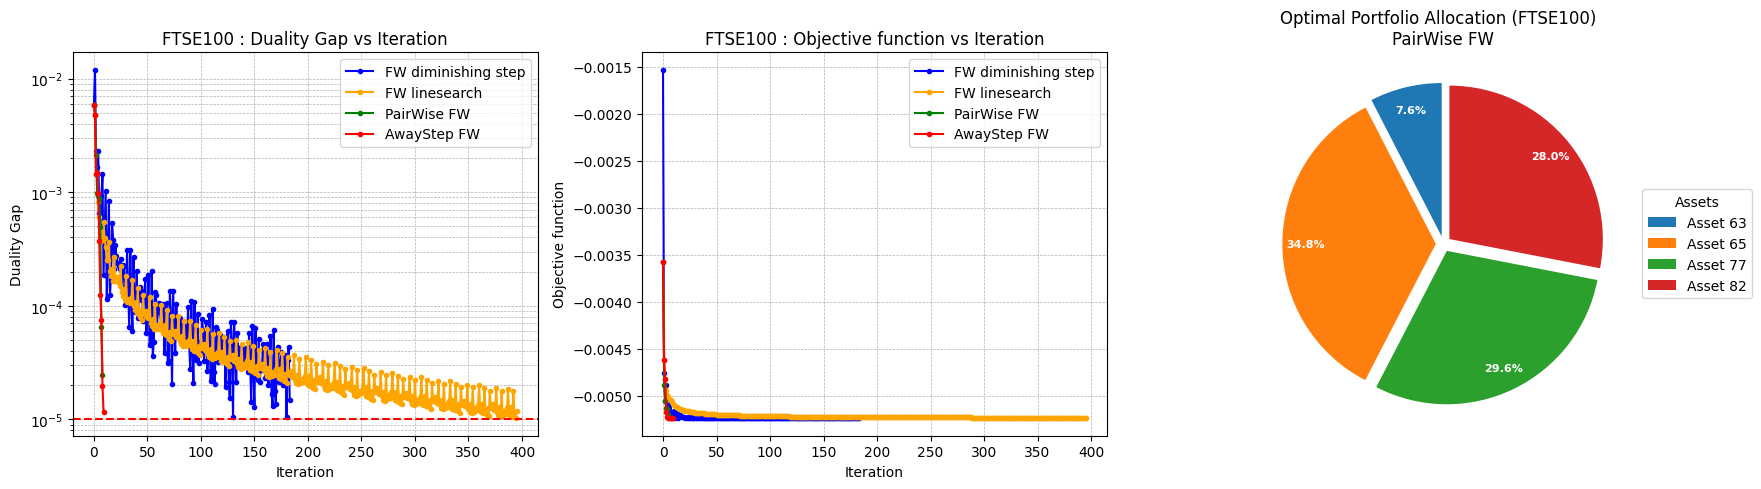

In [91]:
plot_results(history_fw_ftse100_dim, history_fw_ftse100, history_fw_pw_ftse100, history_fw_as_ftse100, x_fw_pw_ftse100, "FTSE100")

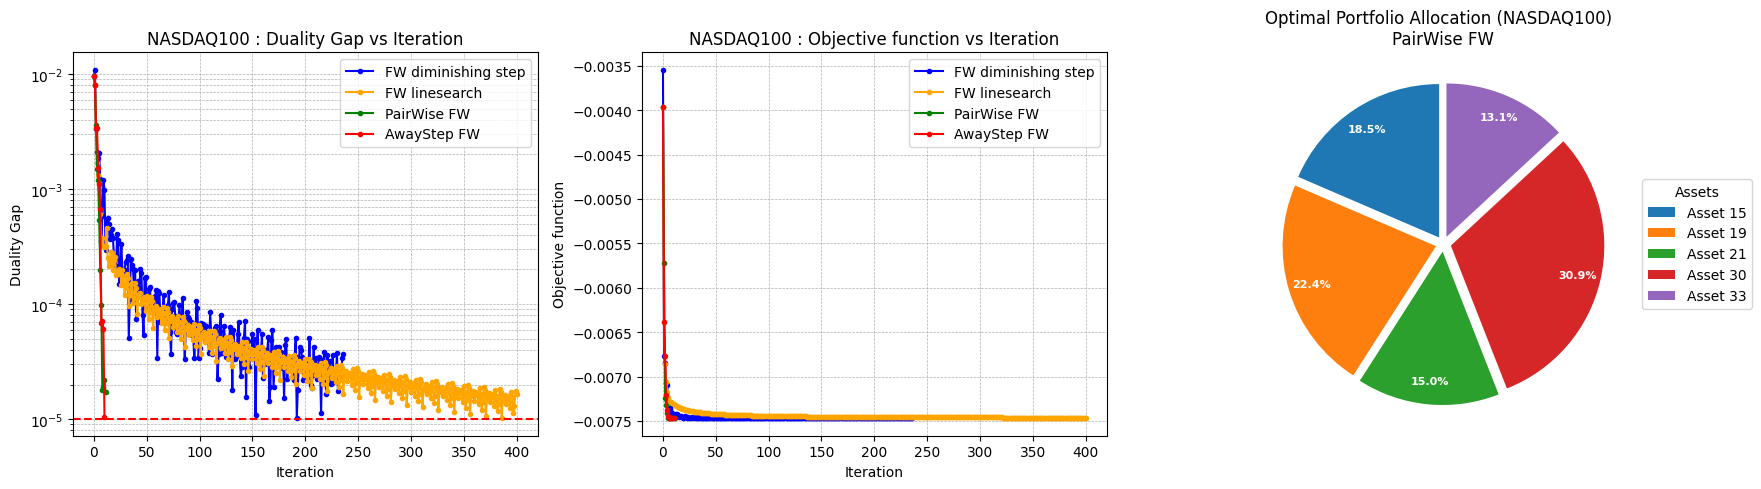

In [92]:
plot_results(history_fw_nasdaq100_dim, history_fw_nasdaq100, history_fw_pw_nasdaq100, history_fw_as_nasdaq100, x_fw_pw_nasdaq100, "NASDAQ100")

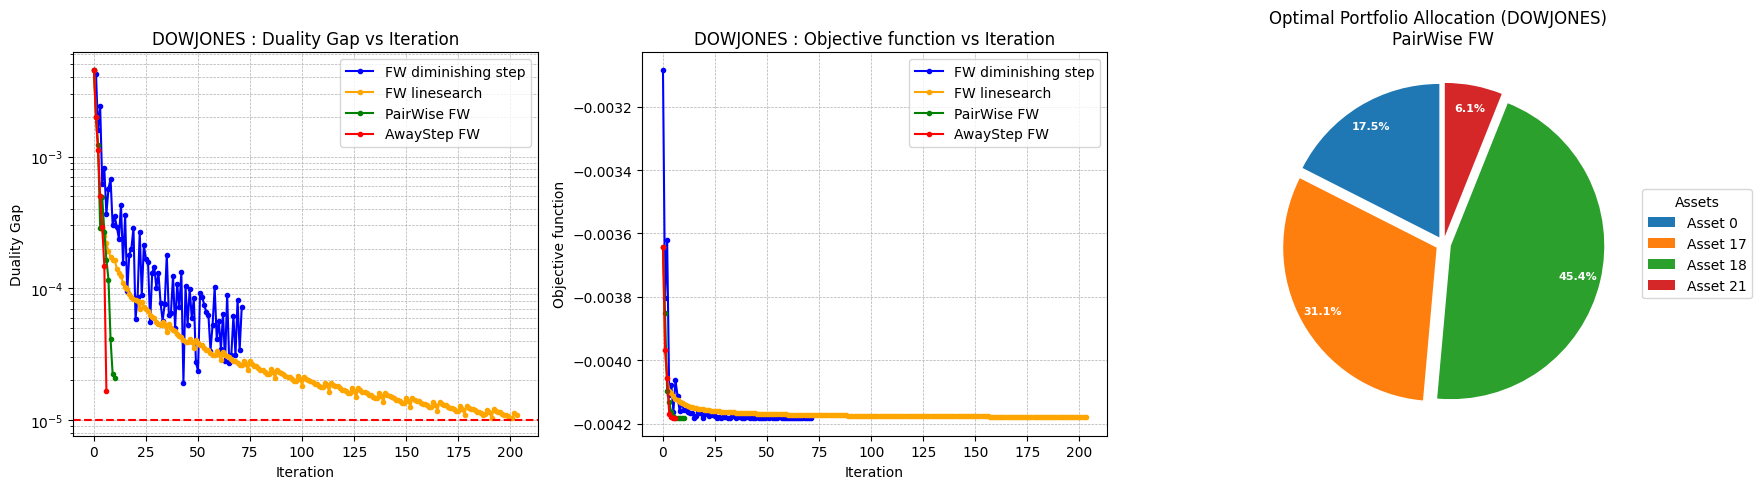

In [93]:
plot_results(history_fw_dowjones_dim, history_fw_dowjones, history_fw_pw_dowjones, history_fw_as_dowjones, x_fw_pw_dowjones, "DOWJONES")

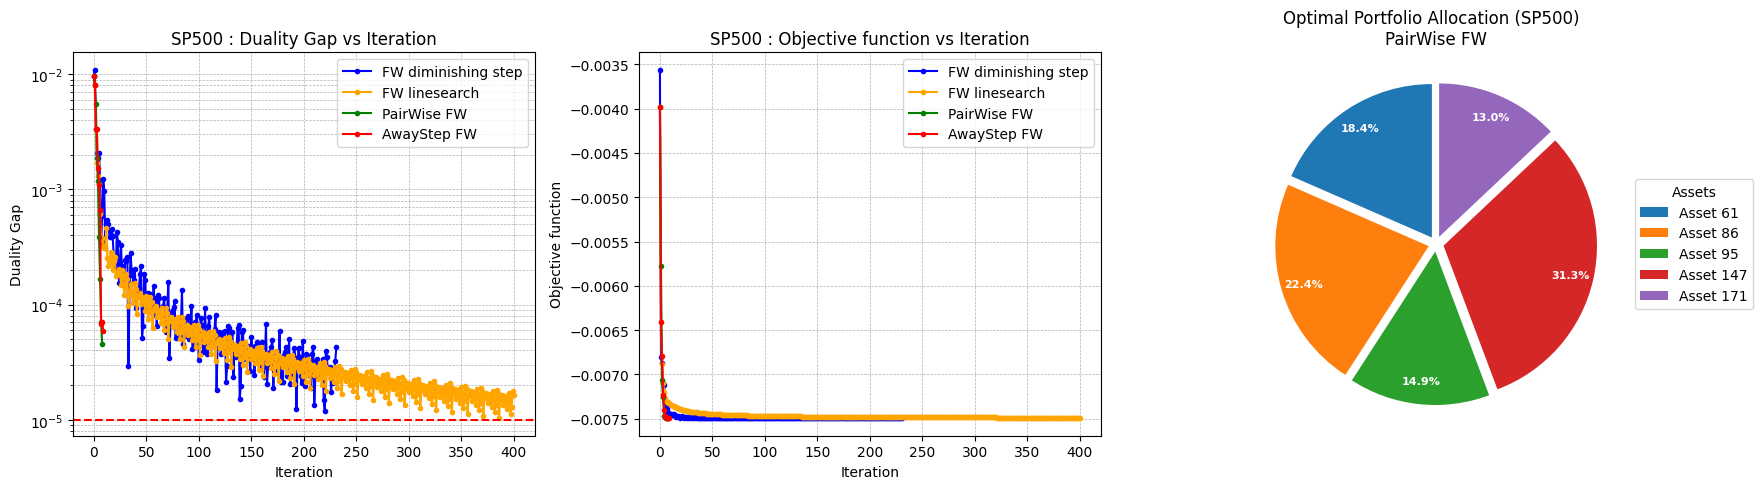

In [94]:
plot_results(history_fw_sp500_dim, history_fw_sp500, history_fw_pw_sp500, history_fw_as_sp500, x_fw_pw_sp500, "SP500")